--------------
# Playbook 9 : MOdified Capsule Network Performance
--------------
Evaluate Capsule Network performance on various fractions of the malaria dataset colour images. Capsule Network has an additional convolution layer
in the input

In [0]:
# Like a great many other libraries in Python, Keras is a mess of incompatability. 
# Need to use 2.2.4 or it breaks the CapsNet Code. I therefore standardise on 
# keras and tensorflow versions
!pip install gast==0.3.2
!pip install keras==2.2.4
!pip install tensorflow==1.15.2

  Created wheel for gast: filename=gast-0.3.2-cp36-none-any.whl size=9680 sha256=05177ab6c9aace9297158bee59566dfc59f59b8c14469b4c65f47d6728bf7757
  Stored in directory: /root/.cache/pip/wheels/59/38/c6/234dc39b4f6951a0768fbc02d5b7207137a5b1d9094f0d54bf
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.3.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
     |████████████████████████████████| 317kB 4.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 110.5MB 38kB/s 
     |████████████████████████████████| 3.8MB 40.5MB/s 
     |████████████████████████████████| 512kB 54.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=42cdb19fc7653ea47a7c8e3ce5b7a7ec53f281542ea540f1f792af060f5be012
  Stored in directo

## 1. Bring zipped data file across from gdrive to extract locally within colab

In [1]:
#%env GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode
%env GPATH=/tf/content/msccode

#from google.colab import drive
#drive.mount('/content/gdrive')
!cp "$GPATH/Datasets/processed-cell-images-malaria.zip" "processed-cell-images-malaria.zip"

env: GPATH=/tf/content/msccode


## 2. Remove existing dataset and extract dataset zip file

In [0]:
!rm -rf cell_images
!rm -rf dataset
!unzip -q 'processed-cell-images-malaria.zip'
!ls

dataset  gdrive  processed-cell-images-malaria.zip  sample_data


## 3. Import required packages

In [5]:
#%tensorflow_version 1.15 

import os
import shutil
import numpy as np
import cv2
import tensorflow as tf
import numpy as np
import keras as keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import pickle
import sys

print(tf.__version__)
print(keras.__version__)

1.15.2
2.2.4


Using TensorFlow backend.


## 4. Define constants

In [6]:
IMG_SIZE = 44         # Data set images will be reframed to this width and height
TEST_FRACTION = 0.1   # Fraction of dataset to hold out for test purposes
VAL_SPLIT = 0.1       # Ammount of training data to use for validation
TEST_SPLIT = 0.1
BATCH_SIZE=32
EPOCHS=60

GPATH=os.environ['GPATH']

# Target image directory for 'processed' color images.
colorData = "./dataset/color/"
dstColorP = "./dataset/color/Parasitized/"
dstColorU = "./dataset/color/Uninfected/"

# Target image directory for 'processed' grayscale images.
grayData = "./dataset/gray/"
dstGrayP = "./dataset/gray/Parasitized/"
dstGrayU = "./dataset/gray/Uninfected/"

dataset_p_dirs=[dstColorP, dstGrayP]
dataset_u_dirs=[dstColorU, dstGrayU]

##5. Define function to load dataset into numpy arrays

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

def loadData(directory, labelMap, as_gray, quiet=True): 
    array_list = [] 
    label_list = []

    labels = [dn for dn in os.listdir(directory) if os.path.isdir(directory + '/' + dn)]

    for label in labels:
        classLabel = labelMap[label]
        subdir = directory + '/' + label
        files = [fn for fn in os.listdir(subdir) if fn.endswith(('.png'))] 
        print("Loading images for class {} from {}".format(classLabel, subdir))
        num_loaded = 0
        for img_file in files:
            file_path = subdir + '/' + img_file
            if as_gray is True:
                img = cv2.imread(file_path, 0)
            else:
                img = cv2.imread(file_path)
            img = img.astype('float32')
            array_list.append(img)
            label_list.append(classLabel)
            num_loaded += 1
            if not quiet:
                if num_loaded % 1000 == 0:
                    print("Loaded %d (of %d)..." %(num_loaded, len(files)))
        print("Completed loading %d (of %d) images" %(num_loaded, len(files)))
        print("")
        
    data = np.array(array_list)
    data /= 255.0
    return data, np.array(label_list)

def load_and_split_data(labelMap={"Uninfected": 0, "Parasitized":1},
                        gray=False, 
                        val_split=VAL_SPLIT, 
                        test_split=TEST_SPLIT):
    print("load_and_split_data called with Val/Test split fraction {}/{}".format(val_split, 
                                                                                 test_split))

    if gray: 
        data_X, data_Y  = loadData(grayData, labelMap, as_gray=True)
    else:
        data_X, data_Y  = loadData(colorData, labelMap, as_gray=False)
    idx = np.random.permutation(len(data_X))
    data_X, data_Y = data_X[idx], data_Y[idx]

    val_X = None; val_Y=None
    test_X = None; test_Y=None
    train_X = data_X; train_y = data_Y

    if test_split > 0:
        train_X, test_X, train_Y, test_Y = train_test_split(data_X, 
                                                            data_Y, 
                                                            test_size=test_split, 
                                                            stratify=data_Y)
    if val_split > 0:
        train_X, val_X, train_Y, val_Y = train_test_split(train_X, 
                                                          train_Y, 
                                                          test_size=val_split, 
                                                          stratify=train_Y)
    if gray:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
    else:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')  

    print("Training data set size is", train_X.shape, train_Y.shape)
    if val_split > 0:
        print("Validation data set size is",val_X.shape, val_Y.shape)
    if test_split > 0:
        print("Test data data set size is",test_X.shape, test_Y.shape)

    labels, counts = np.unique(train_Y, return_counts=True)
    print("Training data labels and counts are", labels, counts)
    if val_split > 0:
        labels, counts = np.unique(val_Y, return_counts=True)
        print("Validation data labels and counts are", labels, counts)
    if test_split > 0:
        labels, counts = np.unique(test_Y, return_counts=True)
        print("Test data labels and counts are", labels, counts)

    return (train_X, train_Y, val_X, val_Y, test_X, test_Y)

def k_fold_load_and_split(gray, splits=10, data_frac=1, test_split=TEST_SPLIT):
    print("k_fold_load_and_split called for {}% data fraction".format(data_frac * 100))
    print("Test split {}%. Number of folds {}".format(test_split * 100,
                                                       splits))

    data_X, data_Y, _, _, test_X, test_Y = load_and_split_data(gray=gray, 
                                                               val_split=0,
                                                               test_split = test_split)

    # Take the required fraction of available training data. 
    if data_frac < 1:
        train_size = int(data_frac * data_X.shape[0])
        test_size = int(data_frac * test_X.shape[0])
        print("Limiting training data to {}/{} samples".format(train_size,
                                                               test_size))
        data_X = data_X[0:train_size]
        data_Y = data_Y[0:train_size]
        test_X = test_X[0:test_size]
        test_Y = test_Y[0:test_size]

    skf = StratifiedKFold(n_splits=splits, shuffle=False) 
    folds = skf.split(data_X, data_Y) 

    return (data_X, data_Y, folds, test_X, test_Y)

##6. Define functions some utility functions for model performaance and accuracy

###6.1 Define function to plot model performance

In [8]:
import matplotlib.pyplot as plt
import math

def plotModelPerf(history, sup = None, file=None):
    # Plot model training and validation loss and accuracy on one graph
    # history is an object provided by a fit() operation on a model
    
    print("Plotting Model accuracy and loss versus epoch")

    length = len(history.history["loss"])
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(8,5))
    for key in history.history.keys():
        if 'caps' in key:
            plt.plot(np.arange(0, length), history.history[key], label=key)    
    if sup is None:
        plt.title("Training Loss and Accuracy", y = 1.05, fontsize=12)
    else:
        plt.title("Training Loss and Accuracy: ({})".format(sup), y = 1.05, fontsize=12)

    plt.xlabel("Epoch #") 
    plt.ylabel("Loss/Accuracy") 
    plt.legend()

    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

# Plot mis-classified images
def show_misclassified(test_Y, pred_Y, ground_truth, file=None):
    pos = 1
    rows = 8
    cols = 10
    fig = plt.figure(figsize=(1.5*cols,1.5*rows))  
    for index in range(len(test_Y)):
        # Look for images where the test label is not the same as predicted
        if test_Y[index] != results[index]:
            pixels = test_X[index]
            #pixels = pixels.reshape((44,44,3))
            label = test_Y[index]
            if label == ground_truth:
                f = fig.add_subplot(rows,cols,pos)
                pos+=1
                f.set_title("T=%d P=%d"% (label, results[index]))
                f.set_xticks([])
                f.set_yticks([])
                plt.imshow(pixels)
            if pos > rows * cols:
                break

    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

def showReconImages(in_imgs, out_imgs, shape, n=10, file = None):
    X, Y, CH = shape

    fig = plt.figure(figsize=(n*1.5, 2*1.5))

    for i in range(n):
        # display original
        f = fig.add_subplot(2, n, i+1)
        pixels = in_imgs[i].reshape(X, Y, CH)
        if len(shape) == 2 or shape[2] == 1:
            plt.imshow(pixels[:,:,0], cmap='gray') 
        else:
            plt.imshow(pixels[:,:,::-1]) # BGR -> RGB
        f.set_xticks([])
        f.set_yticks([])

        # display reconstruction
        f = fig.add_subplot(2, n, i+1 + n)
        pixels = out_imgs[i].reshape(X, Y, CH)
        if len(shape) == 2 or shape[2] == 1:
            plt.imshow(pixels[:,:,0], cmap='gray') 
        else:
            plt.imshow(pixels[:,:,::-1]) # BGR -> RGB
        f.set_xticks([])
        f.set_yticks([])
    
    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

###6.2 Define function to calculate model accuracy

In [9]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def getScores(model, test_X, test_Y):
    # Evaluate the model against the test data set.
    test_YC = keras.utils.np_utils.to_categorical(test_Y)

    results = model.evaluate([test_X, test_YC], [test_YC, test_X], verbose=0) 

    loss = results[0]
    accuracy = results[3]

    resultsProb = model.predict([test_X, test_YC], verbose=0) 
    results = np.argmax(resultsProb[0], axis=1) 

    precision = precision_score(test_Y, results, average='binary')
    recall = recall_score(test_Y, results, average='binary')
    f1 = f1_score(test_Y, results, average='binary')
    return (loss, accuracy, precision, recall, f1)

def showScores(scores):
    loss, accuracy, precision, recall, f1 = scores

    print("")
    print("Scores for classification model")   
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ("Loss", "Accuracy", "Precision", "Recall", "F1"))
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ('-' * 8, '-' * 8, '-' * 8, '-' * 8, '-' * 8)) 
    print("| %-8.3f | %-8.3f | %-9.3f | %-8.3f | %-8.3f"% 
          (loss, accuracy, precision, recall, f1))
      
def showModelScores(model, test_X, test_Y):
    scores = getScores(model, test_X, test_Y)
    showScores(scores)
    return scores

###6.3 Define wrapper function for model training

In [10]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
import random as rand

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rand.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.set_random_seed(1234)

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
seed(11)
(train_X, train_Y, val_X, val_Y, test_X, test_Y) = load_and_split_data(gray=False)
train_YC = keras.utils.np_utils.to_categorical(train_Y)
val_YC = keras.utils.np_utils.to_categorical(val_Y)
test_YC = keras.utils.np_utils.to_categorical(test_Y)

def trainModel(bestFile, model, opt, trainX, trainY, valX, valY, batch, nepochs, 
               verbose=1, 
               es=True):  
    '''
    Define some early stopping conditions. The first one insists a model does better
    than ~51% by the end of one epoch otherwise don't bother. Experience with training
    indicates if a model does not do better than this at the end of one epoch it tends
    to just sit around 50% after each epoch and just does not make progress.
    '''
    cbs = []
    if es is True:
        patience = nepochs//3
        if patience < 10:
            patience = 10
        es1 = EarlyStopping(monitor='out_caps_acc', verbose=verbose, baseline=0.508, patience=2)
        es2 = EarlyStopping(monitor='out_caps_acc', mode='max', verbose=verbose, baseline=0.70, patience=patience)
        #es3 = EarlyStopping(monitor='out_caps_loss', mode='min', verbose=verbose, patience=patience)
        cbs = [es1, es2]

    if bestFile is not None:
        cbs.append(ModelCheckpoint(bestFile, 
                                   monitor='val_out_caps_loss', 
                                   mode='min', 
                                   save_best_only=True))

    model.compile(optimizer=opt,
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics=['accuracy'])

    history = model.fit([trainX, trainY], 
                        [trainY, trainX], 
                        batch_size=batch, 
                        epochs=nepochs,
                        callbacks=cbs,
                        validation_data=[[valX, valY], [valY, valX]],
                        verbose=verbose)
    return history

def CapsTest(k, 
             frac, 
             bs, 
             epochs, 
             f_sizes=[256,256], 
             p_dim=8, 
             d_dim=16,
             s=[1,2],
             mshow = False, 
             es=True,
             plot = True,
             bestFile = None, 
             pltFile = None,
             sup=None,
             verbose=1):
  
    train_size = int(frac * train_X.shape[0]//100)
    val_size = int(frac * val_X.shape[0]//100)

    frac_train_X = train_X[0:train_size]
    frac_train_Y = train_Y[0:train_size]
    frac_train_YC = train_YC[0:train_size]
    frac_val_X = val_X[0:val_size]
    frac_val_Y = val_Y[0:val_size]
    frac_val_YC = val_YC[0:val_size]

    num_tries = 0
    try_again = True

    while try_again:
        K.clear_session()

        model = CapsNet(input_shape=frac_train_X.shape[1:],
                        n_class=2,
                        num_routing=3,
                        k_sizes=k,
                        f_sizes=f_sizes,
                        p_dim=p_dim,
                        d_dim=d_dim,
                        s=s)

        if mshow and (num_tries == 0):
            model.summary()

        hist = trainModel(bestFile, 
                          model, 
                          keras.optimizers.Adam(lr=0.001),
                          frac_train_X, 
                          frac_train_YC,
                          frac_val_X, 
                          frac_val_YC,
                          bs,
                          epochs,
                          es=es,
                          verbose=verbose)
        
        num_tries += 1
        num_epochs = len(hist.history['val_out_caps_acc'])
        if num_epochs > 2:
            scores = hist.history['val_out_caps_acc']
            # Did we exceed treshold in any epoch
            for score in scores:
                if score*100 > 0.70:
                    try_again = False
                    break
            if try_again:
                # Model did'nt train to satisfaction (< tresh accuracy at end of training)
                # So try again.
                print("\tModel rejected. trying again")
                del model
                model = None
        elif num_tries == 10:
            # Failed to tain a model in 10 attempts so give up
            try_again = False
        else:
            del model
            model = None

    scores = getScores(model, test_X, test_Y)

    if plot:
        plotModelPerf(hist, sup=sup, file=pltFile)

    return (model, scores), hist

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (22321, 44, 44, 3) (22321,)
Validation data set size is (2481, 44, 44, 3) (2481,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [11161 11160]
Validation data labels and counts are [0 1] [1240 1241]
Test data labels and counts are [0 1] [1378 1378]


In [11]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

def cv_test(train_X, 
            train_Y, 
            folds, 
            test_X, 
            test_Y, 
            k, 
            f_sizes, 
            p_dim=8, 
            d_dim=16,
            bs=BATCH_SIZE, 
            nepochs=EPOCHS, 
            tresh=80):
    cvscores = []
    es1 = EarlyStopping(monitor='out_caps_acc', verbose=1, baseline=0.508, patience=nepochs//30)
    es2 = EarlyStopping(monitor='out_caps_acc', mode='max', verbose=1, baseline=0.70, patience=nepochs//3)
    #es3 = EarlyStopping(monitor='out_caps_loss', mode='min', verbose=1, patience=nepochs//6)

    train_YC = keras.utils.np_utils.to_categorical(train_Y)
    test_YC = keras.utils.np_utils.to_categorical(test_Y)

    iter = 0
    for train_index, test_index in folds:
        iter += 1
        print("Build and train on fold number {}".format(iter))
        mc = ModelCheckpoint('9_Best_CapsNet_CV_model_{}.h5'.format(iter), 
                              monitor='out_caps_loss', 
                              mode='min', 
                              save_best_only=True)
        
        model_accepted = False
        while model_accepted == False:
            model = CapsNet(input_shape=train_X.shape[1:],
                            n_class=2,
                            num_routing=3,
                            k_sizes=k,
                            f_sizes=f_sizes,
                            p_dim=p_dim,
                            d_dim=d_dim)
            
            model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
                          loss=[margin_loss, 'mse'],
                          loss_weights=[1., 0.0005],
                          metrics=['accuracy'])
      
            model.fit([train_X[train_index], train_YC[train_index]], 
                      [train_YC[train_index], train_X[train_index]], 
                      batch_size=bs, 
                      epochs=nepochs,
                      verbose=0,
                      callbacks=[es1,es2,mc])
    
            # evaluate the model
            scores = getScores(model, train_X[train_index], train_Y[train_index])

            print("\t%s: %.2f%% model score at end of training (with fold test data)" % ('accuracy', scores[1]*100))
            if scores[1]*100 > tresh:
                model_accepted = True 
                model.load_weights('9_Best_CapsNet_CV_model_{}.h5'.format(iter))
                scores = getScores(model, test_X, test_Y)
                print("\t%s: %.2f%% best model score on test set" % ('accuracy', scores[1]*100))
                cvscores.append(scores)
            else:
                print("\tModel rejected. trying again")
 
            K.clear_session()
            del model
            model = None
    return cvscores

##7 Define Capsule Network model functions
The following code is taken from 
* https://www.kaggle.com/kmader/capsulenet-on-mnist, 

This code, is in turn was based on the code by  Xifeng Guo at
* Author: Xifeng Guo, E-mail: guoxifeng1990@163.com, 
* Github: https://github.com/XifengGuo/CapsNet-Keras


In [12]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

In [13]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, num_routing, k_sizes=[9,9], f_sizes=[256,256], p_dim=8, d_dim=16, s=[1,2]):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    if len(k_sizes) == 3:
        conv0 = layers.Conv2D(filters=f_sizes[0], kernel_size=k_sizes[0], strides=s[0], padding='valid', activation='relu', name='conv0')(x)
        conv1 = layers.Conv2D(filters=f_sizes[1], kernel_size=k_sizes[1], strides=s[1], padding='valid', activation='relu', name='conv1')(conv0)
    else:
        conv1 = layers.Conv2D(filters=f_sizes[0], kernel_size=k_sizes[0], strides=s[0], padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=p_dim, n_channels=f_sizes[-1]//p_dim, kernel_size=k_sizes[-1], strides=s[-1], padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=d_dim, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(np.prod(input_shape), activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=input_shape, name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

##8. Build and run the CapsNet Model

###8.1 Define model parameters

In [14]:
F_SIZE=[4,8,8]
K_SIZE=[3,5,9]
S=[1,2,1]
D_DIM = 16

###8.2 Simple test with no Cross Validation

-------------------------------
Testing with filter sizes [4, 8, 8]
Testing with Kernel sizes [3, 5, 9]
Testing with d_dim size 16
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 42, 42, 4)    112         input_12[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 19, 19, 8)    808         conv0[0][0]                      
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 11, 11

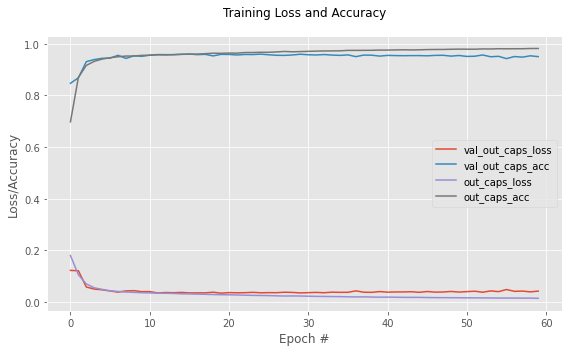


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.033    | 0.960    | 0.967     | 0.954    | 0.960   



In [0]:
print("-------------------------------")
print("Testing with filter sizes {}".format(F_SIZE))
print("Testing with Kernel sizes {}".format(K_SIZE))
print("Testing with d_dim size {}".format(D_DIM))
print("-------------------------------")
frac=100
(model, scores), hist = CapsTest(K_SIZE, 
                                frac=frac, 
                                bs=BATCH_SIZE, 
                                epochs=EPOCHS, 
                                plot=True, 
                                f_sizes=F_SIZE,
                                mshow=True,
                                es=False,
                                s=S,
                                d_dim=D_DIM,
                                bestFile="9_FracTest{}.h5".format(frac),
                                pltFile="9_CapsnetModel_{}_frac{}_f{}.png".format(K_SIZE,
                                                                                   frac, 
                                                                                   F_SIZE))

print("")
print("Best model (min val loss) scores")
model.load_weights("9_FracTest{}.h5".format(frac))
showModelScores(model, test_X, test_Y)
print("") 
m100 = model

###8.3 Test with 10-fold Cross Validation

In [0]:
frac=100
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 100.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]

Build and train on fold number 1
	accuracy: 97.08% model score at end of training (with fold test data)
	accuracy: 94.45% best model score on test set
Build and train on fold number 2
	accuracy: 98.53% model score at end of training (with fold test data)
	accuracy: 94.38% best model score on test set
Build and train on fold number 3
	accuracy: 97.24% model score at end of training (with fold test data)
	accuracy: 94.38% be

##9. Model performance with different fractions of available training data

In [16]:
def fracTest(frac, k_size, f_size, d_dim, verbose=0, es=False):
    print("-------------------------------")
    print("Testing with filter sizes {}".format(f_size))
    print("Testing with Kernel sizes {}".format(k_size))
    print("Testing with d_dim size {}".format(d_dim))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=(EPOCHS * 100)//frac, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    es=es,
                                    verbose=verbose,
                                    d_dim=d_dim,
                                    sup= "{}% training data".format(frac),
                                    bestFile="9_FracTest{}.h5".format(frac),
                                    pltFile="9_CapsnetModel_{}_frac{}_f{}.png".format(k_size,
                                                                                       frac, 
                                                                                       f_size))
    print("")
    print("Best model (min val loss) scores")
    model.load_weights("9_FracTest{}.h5".format(frac))
    showModelScores(model, test_X, test_Y)
    print("") 
    return (model, scores)

-------------------------------
Testing with filter sizes [4, 8, 8]
Testing with Kernel sizes [3, 5, 9]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


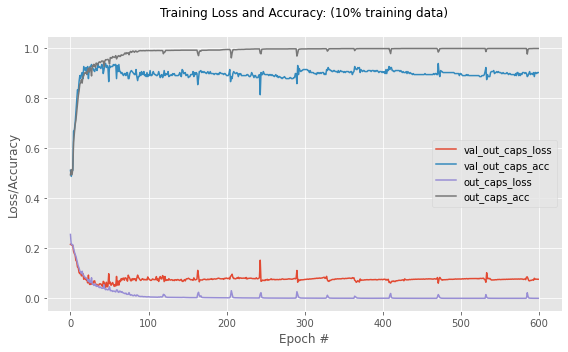


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.071    | 0.905    | 0.885     | 0.930    | 0.907   



(<keras.engine.training.Model at 0x7f5354082c88>,
 (0.083966998515665,
  0.9034833091436865,
  0.9040697674418605,
  0.9027576197387518,
  0.9034132171387075))

In [0]:
fracTest(10, K_SIZE, F_SIZE, D_DIM)

-------------------------------
Testing with filter sizes [4, 8, 8]
Testing with Kernel sizes [3, 5, 9]
Testing with d_dim size 16
-------------------------------





Instructions for updating:
dim is deprecated, use axis instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







Plotting Model accuracy and loss versus epoch


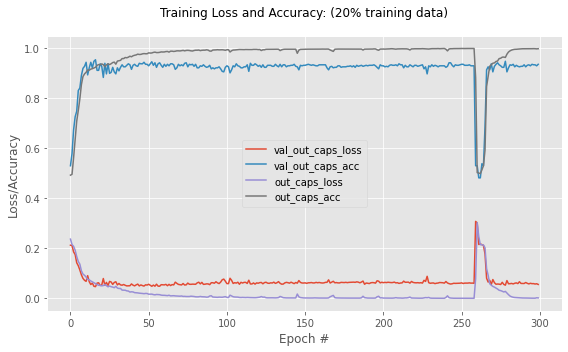


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.070    | 0.915    | 0.916     | 0.914    | 0.915   



(<keras.engine.training.Model at 0x7f5a4b8eedd8>,
 (0.06501010463389571,
  0.9219883889695211,
  0.9297856614929786,
  0.9129172714078374,
  0.9212742585133651))

In [0]:
fracTest(20, K_SIZE, F_SIZE, D_DIM)

-------------------------------
Testing with filter sizes [4, 8, 8]
Testing with Kernel sizes [3, 5, 9]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


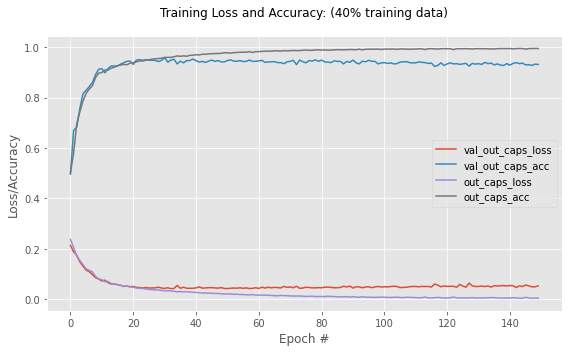


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.049    | 0.934    | 0.941     | 0.927    | 0.934   



(<keras.engine.training.Model at 0x7f59e39985f8>,
 (0.0541138622966767,
  0.9343251088534107,
  0.9397501836884644,
  0.9281567489114659,
  0.9339174881343557))

In [0]:
fracTest(40, K_SIZE, F_SIZE, D_DIM)

-------------------------------
Testing with filter sizes [4, 8, 8]
Testing with Kernel sizes [3, 5, 9]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


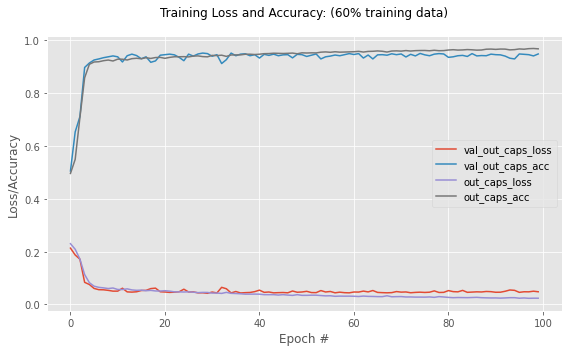


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.058    | 0.925    | 0.917     | 0.935    | 0.926   



(<keras.engine.training.Model at 0x7f59e23b97b8>,
 (0.06103144528774115,
  0.9292452830188679,
  0.9352465047829286,
  0.9223512336719883,
  0.928754110339788))

In [0]:
fracTest(60, K_SIZE, F_SIZE, D_DIM)

-------------------------------
Testing with filter sizes [4, 8, 8]
Testing with Kernel sizes [3, 5, 9]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


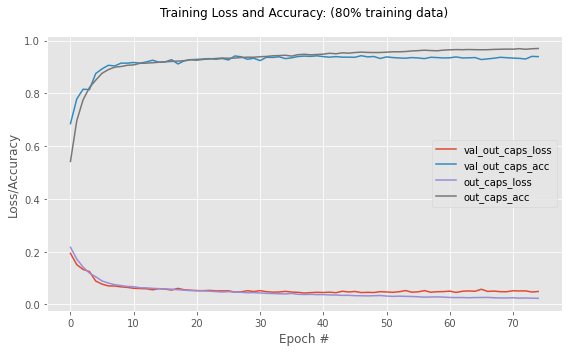


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.058    | 0.920    | 0.909     | 0.933    | 0.921   



(<keras.engine.training.Model at 0x7f59aff79278>,
 (0.05829416599995842,
  0.9252539912917271,
  0.9209770114942529,
  0.93033381712627,
  0.9256317689530686))

In [0]:
fracTest(80, K_SIZE, F_SIZE, D_DIM)

-------------------------------
Testing with filter sizes [4, 8, 8]
Testing with Kernel sizes [3, 5, 9]
Testing with d_dim size 16
-------------------------------





Instructions for updating:
dim is deprecated, use axis instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







Plotting Model accuracy and loss versus epoch


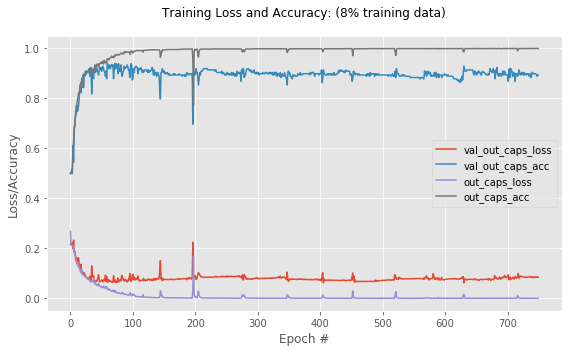


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.076    | 0.910    | 0.935     | 0.882    | 0.907   

-------------------------------
Testing with filter sizes [4, 8, 8]
Testing with Kernel sizes [3, 5, 9]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


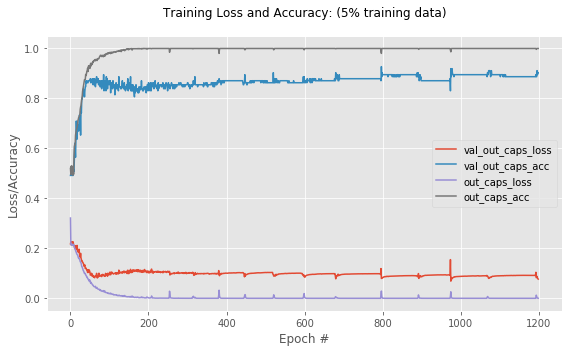


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.093    | 0.889    | 0.891     | 0.885    | 0.888   

-------------------------------
Testing with filter sizes [4, 8, 8]
Testing with Kernel sizes [3, 5, 9]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


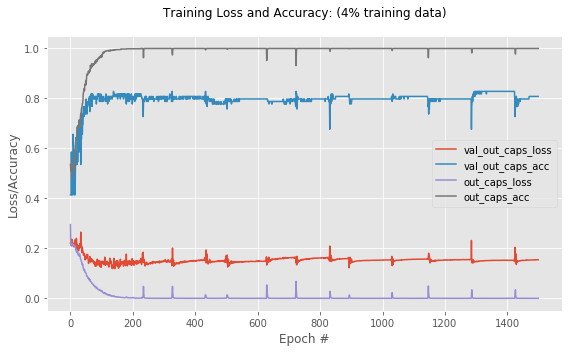


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.153    | 0.759    | 0.791     | 0.704    | 0.745   

-------------------------------
Testing with filter sizes [4, 8, 8]
Testing with Kernel sizes [3, 5, 9]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


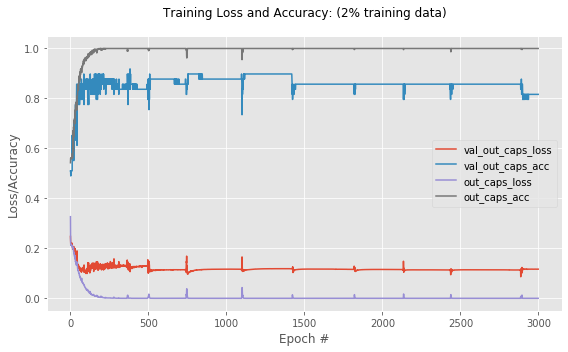


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.155    | 0.768    | 0.781     | 0.745    | 0.763   



In [17]:
for frac in [8,5,4,2]:
    fracTest(frac, K_SIZE, F_SIZE, D_DIM)

##10. CV Test for data Fractions

In [0]:
frac=10
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 10.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 2480/275 samples

Build and train on fold number 1



Instructions for updating:
dim is deprecated, use axis instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







Epoch 00517: early stopping
	accuracy: 100.00% model score at end of training (with fold test data)
	accuracy: 88.36% best model score on test set


Build and train on fold number 2
E

In [0]:
frac=20
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 20.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 4960/551 samples

Build and train on fold number 1
	accuracy: 99.89% model score at end of training (with fold test data)
	accuracy: 92.01% best model score on test set
Build and train on fold number 2
	accuracy: 99.96% model score at end of training (with fold test data)
	accuracy: 94.01% best model score on test set
Build and train on fold number 3
	accuracy: 99.91% model score at end of training 

In [0]:
frac=40
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 40.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 9920/1102 samples

Build and train on fold number 1



Instructions for updating:
dim is deprecated, use axis instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







	accuracy: 99.70% model score at end of training (with fold test data)
	accuracy: 94.10% best model score on test set


Build and train on fold number 2
	accuracy: 99.62% model score

In [0]:
frac=60
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 60.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 14881/1653 samples

Build and train on fold number 1
	accuracy: 99.28% model score at end of training (with fold test data)
	accuracy: 94.07% best model score on test set
Build and train on fold number 2
	accuracy: 97.70% model score at end of training (with fold test data)
	accuracy: 93.77% best model score on test set
Build and train on fold number 3
	accuracy: 99.04% model score at end of trainin

In [0]:
frac=80
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 80.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 19841/2204 samples

Build and train on fold number 1
	accuracy: 98.15% model score at end of training (with fold test data)
	accuracy: 93.69% best model score on test set
Build and train on fold number 2
	accuracy: 98.11% model score at end of training (with fold test data)
	accuracy: 94.01% best model score on test set
Build and train on fold number 3
	accuracy: 98.21% model score at end of trainin

##11 Confusion Matrix and Mis-classified images
###11.1 Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

model = m100

showScores(getScores(model, test_X, test_Y))

resultsProb = model.predict([test_X, test_YC], verbose=0) 
# calculate predicted results from probabilities (horizontal axis)
results = np.argmax(resultsProb[0], axis=1) 
# Show the confusion matrix
print(confusion_matrix(test_Y, results))


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.038    | 0.957    | 0.970     | 0.943    | 0.956   
[[1338   40]
 [  79 1299]]


###11.2 Mis-classified images

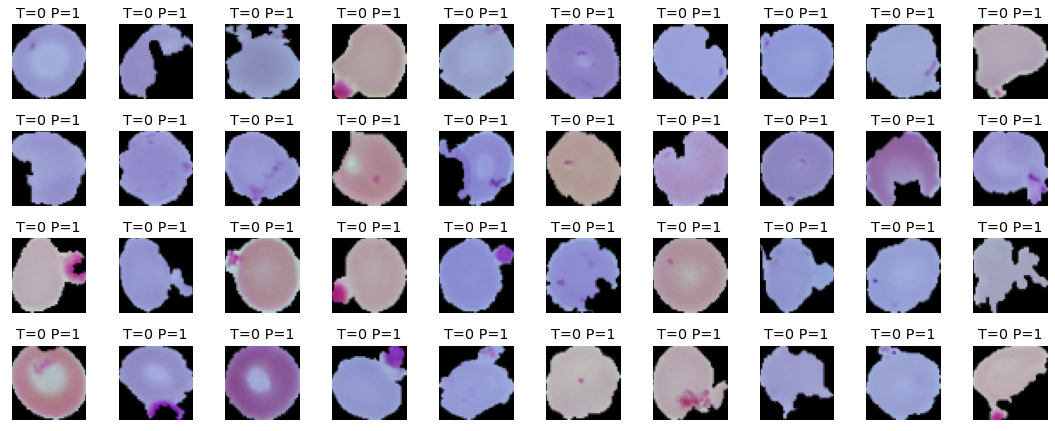

In [0]:
# Show the False Positive IMages
show_misclassified(test_Y, results, ground_truth=0, file='9_Caps_misclassified_T0P1.png')

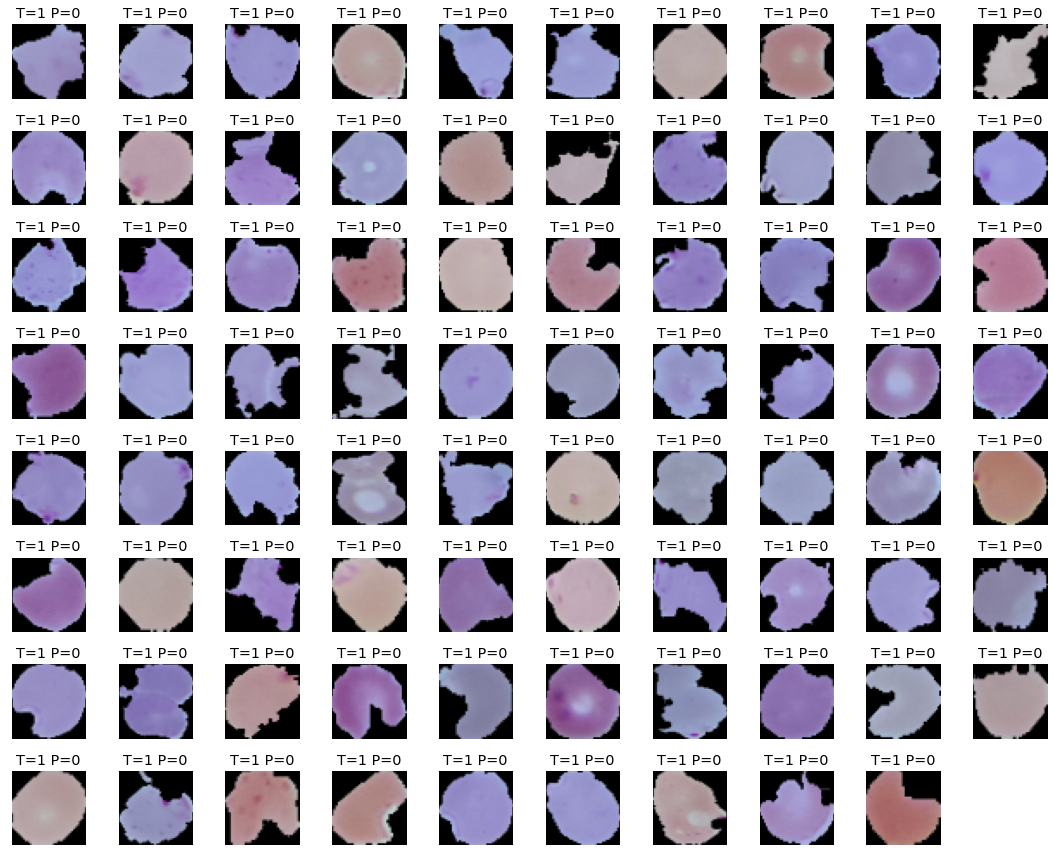

In [0]:
# Show the False Negative Images
show_misclassified(test_Y, results, ground_truth=1, file='9_Caps_misclassified_T1P0.png')

### 11.4 Visualise layers

This code is taken from from https://fairyonice.github.io/Visualization%20of%20Filters%20with%20Keras.html

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from keras import backend as K

class VisualizeImageMaximizeFmap(object):
    def __init__(self,pic_shape, model):
        '''
        pic_shape : a dimention of a single picture e.g., (96,96,1)
        '''
        self.pic_shape = pic_shape
        self.model = model

    def find_n_feature_map(self, layer_name ,max_nfmap):
        '''
        shows the number of feature maps for this layer
        only works if the layer is CNN
        '''
        n_fmap = None
        for layer in self.model.layers:
            if layer.name == layer_name:
                weights = layer.get_weights()
                n_fmap=weights[1].shape[0]
        if n_fmap is None:
            print(layer_name + " is not one of the layer names..")
            n_fmap = 1
        n_fmap = np.min([max_nfmap,n_fmap])
        return(int(n_fmap))

    def find_image_maximizing_activation(self,
                                         iterate,
                                         input_img_data,
                                         picorig=False,
                                         n_iter = 30):
        '''
        The input image is scaled to range between 0 and 1
        picorig  : True  if the picture image for input is original scale
                         ranging between 0 and 225
                   False if the picture image for input is ranging [0,1]
        '''
            
        input_img_data = np.random.random((1, 
                                           self.pic_shape[0],
                                           self.pic_shape[1],
                                           self.pic_shape[2]))
        if picorig:
            ## if the original picture is unscaled and ranging between (0,225),
            ## then the image values are centered around 123 with STD=25
            input_img_data = input_img_data*25 + 123 


        ## I played with this step value but the final image looks to be robust
        step = 500 

        # gradient ascent
        loss_values = []
        for i in range(n_iter):
            loss_value, grads_value = iterate([input_img_data, 0])
            input_img_data += grads_value * step
            loss_values.append(loss_value) 
        return (input_img_data, loss_values)

    def create_iterate(self,input_img, layer_output, filter_index):
        '''
        layer_output[:,:,:,0] is (Nsample, 94, 94) tensor contains:
        W0^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        layer_output[:,:,:,1] contains:
        W1^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        W0 and W1 are different kernel!
        '''
        ## loss is a scalar 
        if len(layer_output.shape) == 4:
            ## conv layer 
            loss = K.mean(layer_output[:,  :, :, filter_index])
        elif len(layer_output.shape) ==2:
            ## fully connected layer
            loss = K.mean(layer_output[:, filter_index])
         
        # calculate the gradient of the loss evaluated at the provided image
        grads = K.gradients(loss, input_img)[0]
        # normalize the gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # iterate is a function taking (input_img, scalar) and output [loss_value, gradient_value]
        iterate = K.function([input_img, K.learning_phase()], [loss, grads])
        return(iterate)

    def deprocess_image(self,x):
        # standardize to have a mean 0 and std  0.1 
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 0.1

        # Shift x to have a mean 0.5 and std 0.1
        # This means 95% of the x should be in between 0 and 1
        # if x is normal
        x += 0.5
        x = np.clip(x, 0, 1)

        # resclar the values to range between 0 and 255
        x *= 255
        x = np.clip(x, 0, 255).astype('uint8')

        return x

    def find_images(self,
                    input_img,
                    layer_names,
                    layer_dict, 
                    max_nfmap,
                    picorig=False,
                    n_iter=30):
        '''
        Input :

        input_img   : the alias of the input layer from the deep learning model
        layer_names : list containing the name of the layers whose feature maps to be used
        layer_dict  : symbolic outputs of each "key" layer (we gave them unique names).
        max_nfmap   : the maximum number of feature map to be used for each layer.
        pic_shape   : For example pic_shape = (96,96,1)

        Output : 
        dictionary 

        key = layer name 
        value = a list containing the tuple of (images, list of loss_values) that maximize each feature map
        '''
        argimage = {}
        ## Look for the image for each feature map of each layer one by one
        for layer_name in layer_names: ## the layer to visualize
            n_fmap = self.find_n_feature_map(layer_name,max_nfmap)
            layer_output = layer_dict[layer_name].output
            result = self.find_images_for_layer(input_img,
                                                layer_output,
                                                range(n_fmap),
                                                picorig=picorig,
                                                n_iter=n_iter)

            argimage[layer_name] = result
        return(argimage)

    def find_images_for_layer(self,
                              input_img,
                              layer_output,
                              indices,
                              picorig=False,
                              n_iter=30):
        '''
        indices : list containing index of 
                      --> filtermaps of CNN or 
                      --> nodes of fully-connected layer
        Output

        a list containing the tuple of (images, list of loss_values) 
        that maximize each feature map


        '''
        result_temp = []
        for filter_index in indices: # filtermap to visualize
                iterate = self.create_iterate(input_img, layer_output,filter_index)
                input_img_data, loss_values = self.find_image_maximizing_activation(
                    iterate,input_img,
                    picorig=picorig,
                    n_iter=n_iter)
                result_temp.append((input_img_data,loss_values))
        return(result_temp)

    def plot_images_wrapper(self,argimage,n_row = 8, scale = 1):
        '''
        scale : scale up or down the plot size
        '''
        pic_shape = self.pic_shape
        if pic_shape[2] == 1:
            pic_shape = self.pic_shape[:2]
        layer_names = argimage.keys() # np.sort(argimage.keys())

        for layer_name in layer_names:
            n_fmap = len(argimage[layer_name])
            n_col = np.ceil(n_fmap/float(n_row))
            fig = plt.figure(figsize=(n_col*scale,
                                      n_row*scale))
            fig.subplots_adjust(hspace=0.001,wspace=0.001)
            plt.title(layer_name + " n_featuremap=" + str(n_fmap))
            count = 1
            for value in argimage[layer_name]:
                input_img_data = value[0][0]
                img = self.deprocess_image(input_img_data)
                ax = fig.add_subplot(n_row,n_col,count,
                                    xticks=[],yticks=[])
                ax.imshow(img.reshape(*pic_shape),cmap="gray")
                count += 1
            plt.show()

find images that maximize feature maps

plot them...


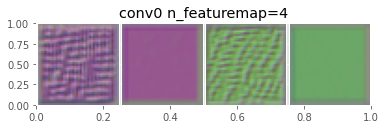

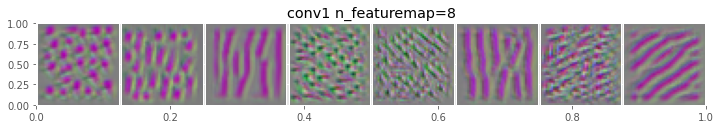

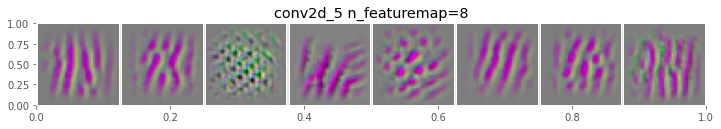

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

input_img = model.layers[0].input
layer_names = [model.layers[1].name, model.layers[2].name,  model.layers[3].name]
layer_dict = dict([(layer.name, layer) for layer in model.layers])

max_nfmap = 256 #np.Inf ## print ALL the images

visualizer = VisualizeImageMaximizeFmap(pic_shape = (44,44,3), model=model)
print("find images that maximize feature maps")
argimage = visualizer.find_images(input_img,
                                  layer_names,
                                  layer_dict, 
                                  max_nfmap)
print("plot them...")
visualizer.plot_images_wrapper(argimage, n_row = 1, scale = 1.5)

### 11.5 Show Reconstruction Images. 
Note that we encode so little information that the decoder is only capable of producing a cell outline.

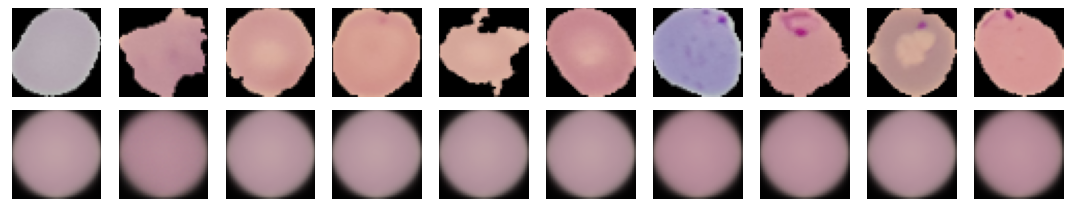

In [0]:
def genCapsReconImgs(model, data, file=None):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=x_test.shape[0])
    _, W, H, C = x_test.shape
    shape = (W, H, C)
    showReconImages(x_test, x_recon, shape, n=10, file=file)

genCapsReconImgs(model=model, data=(test_X[:20], test_YC[:20]), file='9_CAPS_recon.png')

##12 Save models and images

In [19]:
%%bash
cp -f ./*.h5 "$GPATH/Models"
cp -f ./*.json "$GPATH/Models"
cp -f ./*.png "$GPATH/Images"

cp: cannot stat './*.json': No such file or directory
